**Experimenting with KOI Dataset**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.preprocessing import label_binarize

!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


**Loading & Observing Dataset**

In [ ]:
df = pd.read_csv('KOI.csv', comment='#')
print(df.head())
print(df.shape)
print(df.info())

      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \


**Checking & Plotting whether the dataset is Imbalanced or not**

Candidate : 1979
False : 4839
Confirmed : 2746


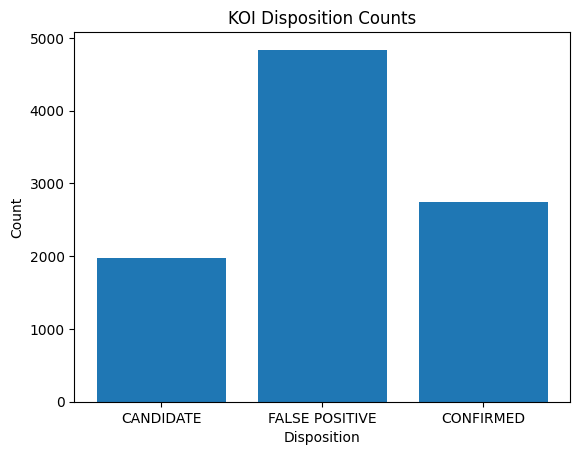

In [ ]:
count_candidate = (df['koi_disposition'] == 'CANDIDATE').sum()
count_false = (df['koi_disposition'] == 'FALSE POSITIVE').sum()
count_confirmed = (df['koi_disposition'] == 'CONFIRMED').sum()

print(f"Candidate : {count_candidate}")
print(f"False : {count_false}")
print(f"Confirmed : {count_confirmed}")

labels = ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']
counts = [count_candidate, count_false, count_confirmed]

plt.bar(labels, counts)
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.title('KOI Disposition Counts')
plt.show()

**Checking for the column with null values**

In [ ]:
columns_with_nan = df.columns[df.isnull().any()]
print(columns_with_nan)

Index(['kepler_name', 'koi_score', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1',
       'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2',
       'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad',
       'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1',
       'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff',
       'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1',
       'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2',
       'koi_kepmag'],
      dtype='object')


**Segregating Columns with & without Error**

In [ ]:
# Columns with 'err'
err_columns = [col for col in columns_with_nan if 'err' in col]

# Columns without 'err'
non_err_columns = [col for col in columns_with_nan if 'err' not in col]

print("Columns without 'err':", non_err_columns)
print("Columns with 'err':", err_columns)

Columns without 'err': ['kepler_name', 'koi_score', 'koi_impact', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag']
Columns with 'err': ['koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol_err1', 'koi_insol_err2', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad_err1', 'koi_srad_err2']


**Plotting errors**

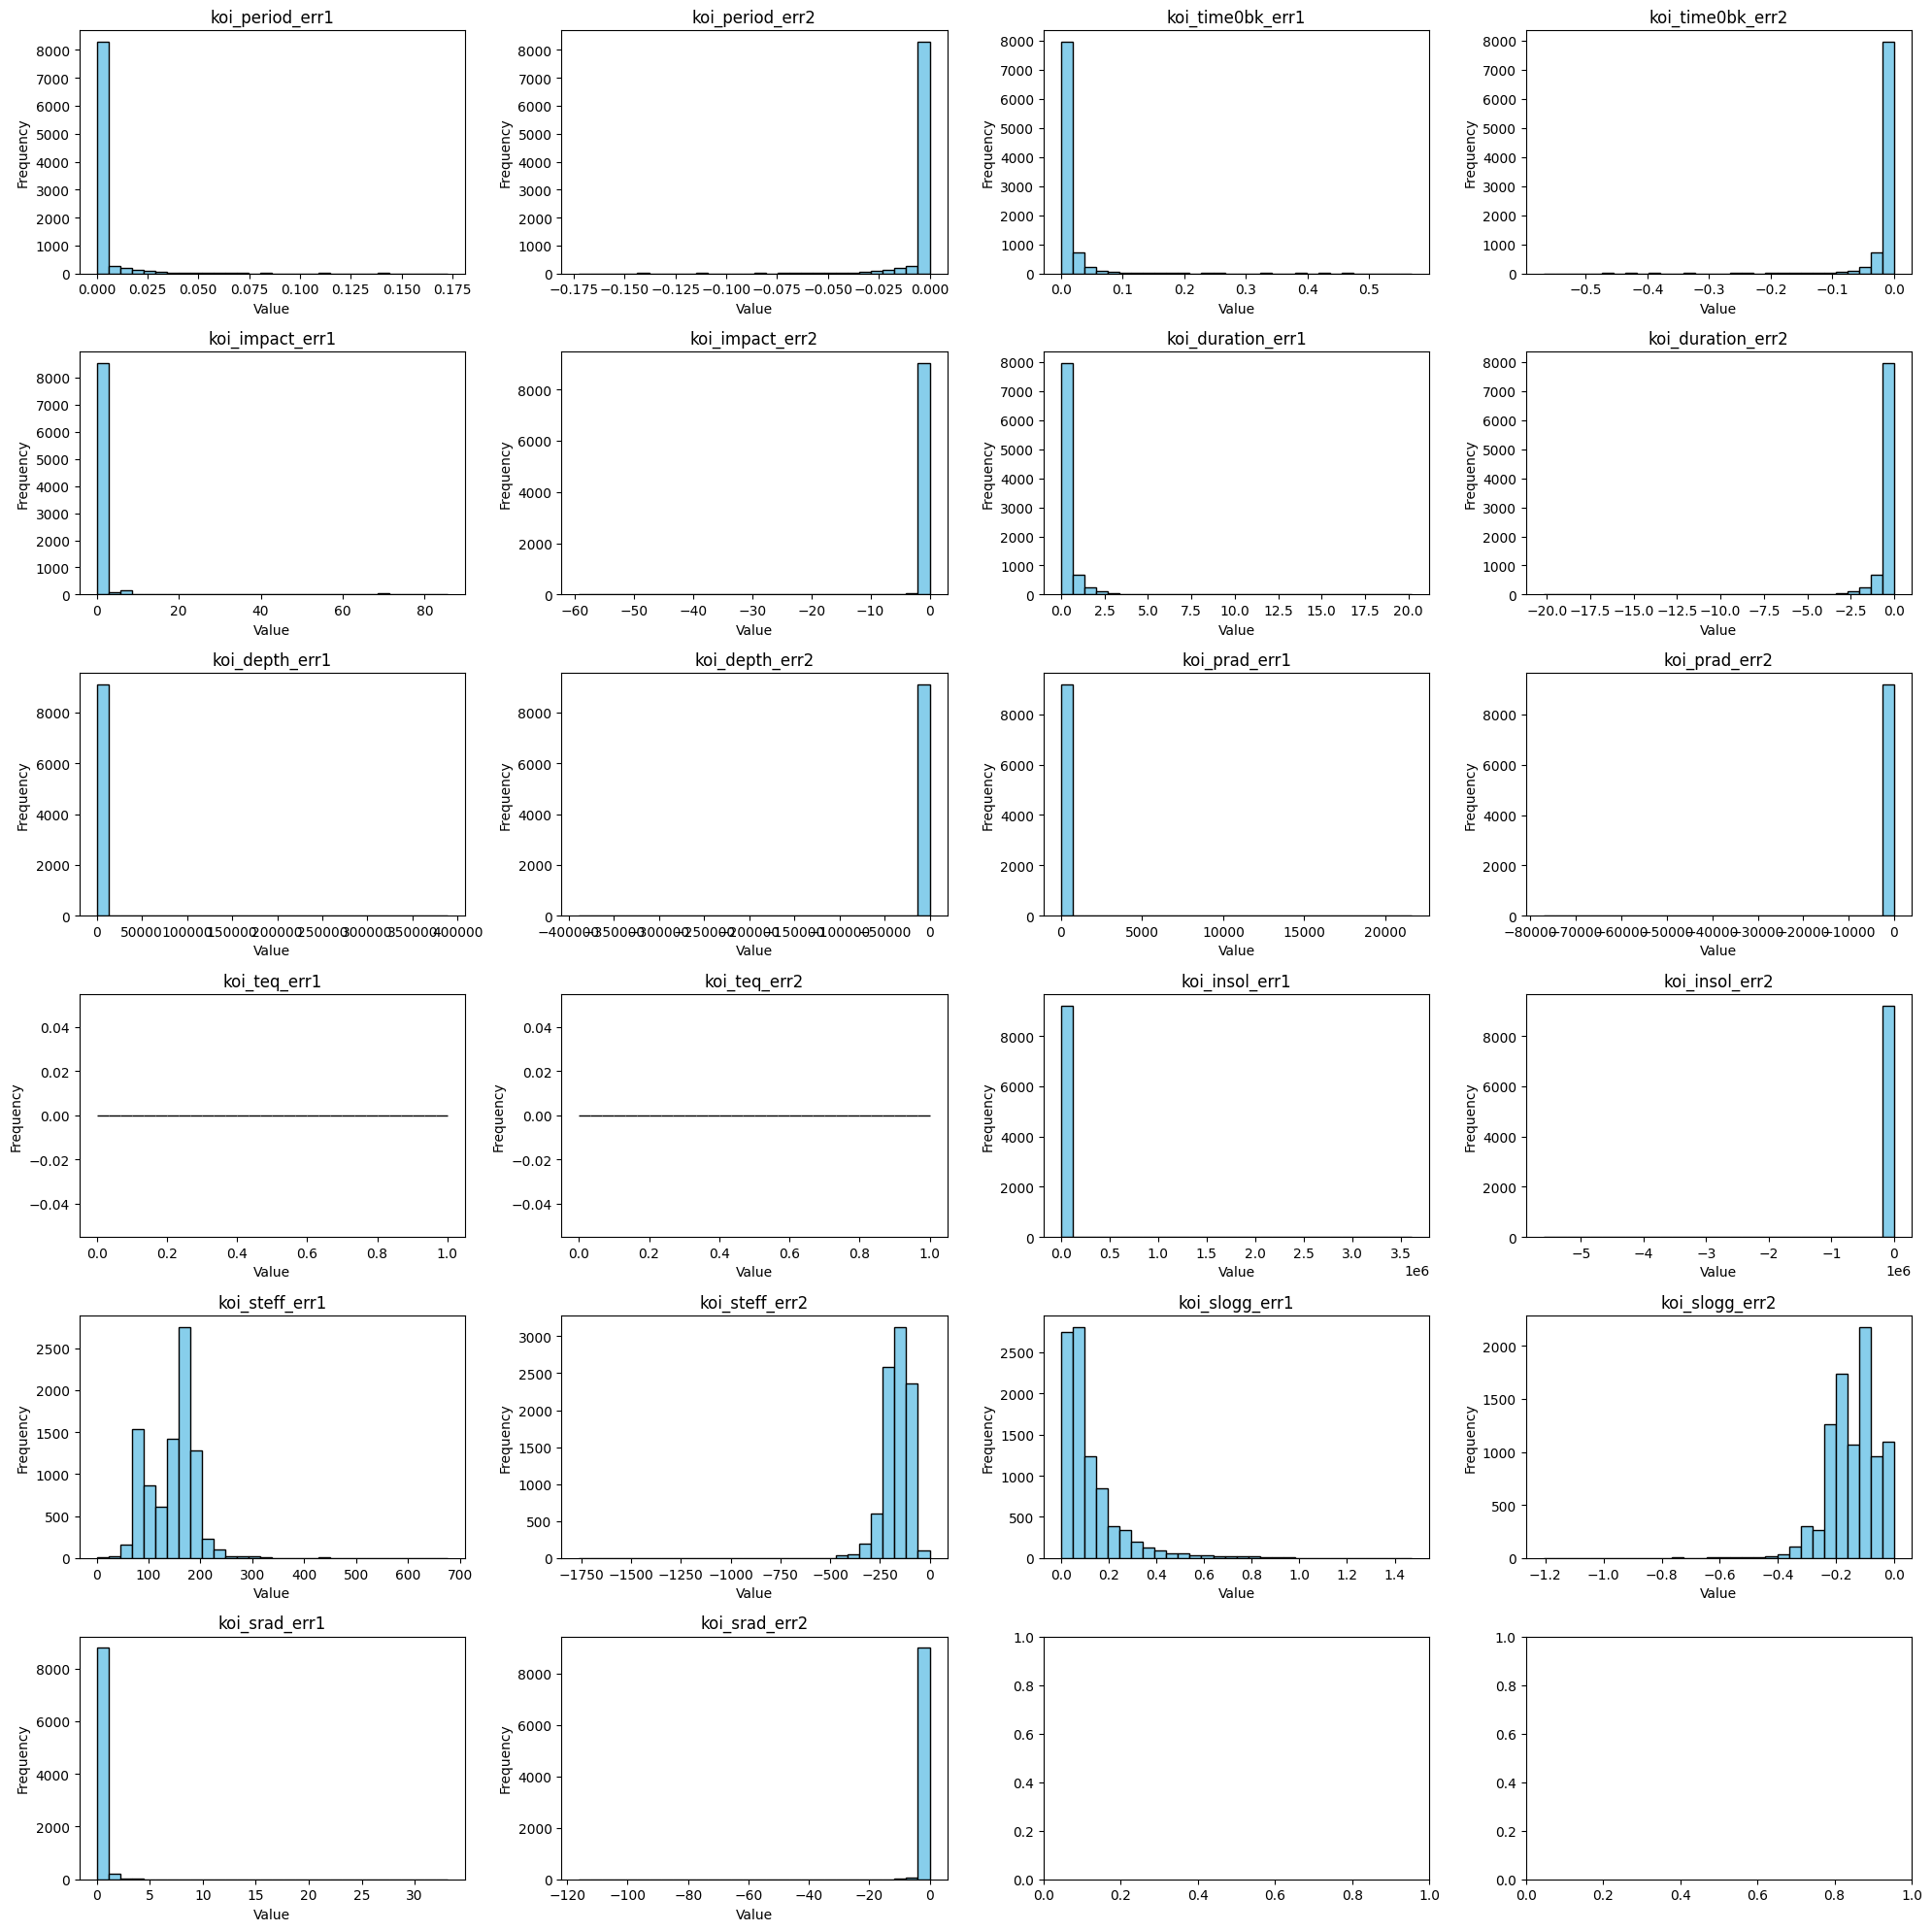

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20)) # Increased nrows to accommodate all columns
axes = axes.flatten()

for i, col in enumerate(err_columns):
    data = df[col].dropna()
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Dropping columns along with Kepler_name column**
**❗preventing data leakage**

In [ ]:
columns_to_drop = err_columns + ['kepler_name', 'koi_fpflag_nt',	'koi_fpflag_ss',	'koi_fpflag_co',	'koi_fpflag_ec']
df = df.drop(columns=columns_to_drop)
df.shape

(9564, 22)

**Encoding the labels**

In [ ]:
encode_map = {
    "FALSE POSITIVE": 0,
    "CANDIDATE": 1,
    "CONFIRMED": 2
}

df['koi_pdisposition_bin'] = df['koi_pdisposition'].map({
    'CANDIDATE': 1,
    'FALSE POSITIVE': 0
})

df["koi_disposition_encoded"] = df["koi_disposition"].map(encode_map)

**Selecting the imp columns & creating sample X and target y**

In [ ]:
imp_columns = ['koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_impact',
'koi_model_snr', 'koi_score',
'koi_pdisposition_bin',
'koi_steff', 'koi_srad', 'koi_slogg'
]

y = df['koi_disposition_encoded']
X = df[imp_columns].copy()

**Using log scaling for skewness**

In [ ]:
X['koi_depth'] = X['koi_depth'].fillna(X['koi_depth'].median())
X['koi_depth_log'] = np.log1p(X['koi_depth'])         # log(1+x)
X['koi_model_snr'] = X['koi_model_snr'].fillna(df['koi_model_snr'].median())
X['koi_model_snr_log'] = np.log1p(X['koi_model_snr'])

**Adding a feature that whether score feature was missing or not**

In [ ]:
X['koi_score_missing'] = X['koi_score'].isna().astype(int)

**Imputing the missing values**

In [ ]:
imputer = SimpleImputer(strategy='median')
impute_cols = ['koi_steff', 'koi_srad', 'koi_slogg']

# Fit/transform only on selected columns
X[impute_cols] = imputer.fit_transform(X[impute_cols])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   koi_period            9564 non-null   float64
 1   koi_time0bk           9564 non-null   float64
 2   koi_duration          9564 non-null   float64
 3   koi_depth             9564 non-null   float64
 4   koi_prad              9201 non-null   float64
 5   koi_impact            9201 non-null   float64
 6   koi_model_snr         9564 non-null   float64
 7   koi_score             8054 non-null   float64
 8   koi_pdisposition_bin  9564 non-null   int64  
 9   koi_steff             9564 non-null   float64
 10  koi_srad              9564 non-null   float64
 11  koi_slogg             9564 non-null   float64
 12  koi_depth_log         9564 non-null   float64
 13  koi_model_snr_log     9564 non-null   float64
 14  koi_score_missing     9564 non-null   int64  
dtypes: float64(13), int64

**Imputing planet radius & impact feature value using KNNImputer**

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
impute_features = ['koi_prad', 'koi_depth', 'koi_impact', 'koi_duration', 'koi_steff', 'koi_srad']
imputed_block = knn_imputer.fit_transform(
    X[impute_features]
)

imputed_block = pd.DataFrame(imputed_block, columns=impute_features, index=X.index)

X['koi_prad'] = imputed_block['koi_prad']
X['koi_impact'] = imputed_block['koi_impact']

**Checking for MultiCollinearity**

In [ ]:
vif_cols = [
    'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_impact',
    'koi_model_snr', 'koi_score',
    'koi_steff', 'koi_srad', 'koi_slogg',
    'koi_depth_log', 'koi_model_snr_log'
]

X_for_vif = X[vif_cols].copy()

# Impute missing values in 'koi_score'
imputer_score = SimpleImputer(strategy='median')
X_for_vif['koi_score'] = imputer_score.fit_transform(X_for_vif[['koi_score']])

vif_data = pd.DataFrame()
vif_data['feature'] = X_for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_for_vif.values, i)
                   for i in range(X_for_vif.shape[1])]
print(vif_data)

              feature        VIF
0          koi_period   1.013377
1         koi_time0bk   8.161763
2        koi_duration   1.932558
3           koi_depth   2.326267
4            koi_prad   1.863496
5          koi_impact   1.968428
6       koi_model_snr   2.581558
7           koi_score   2.432567
8           koi_steff  39.138937
9            koi_srad   1.192052
10          koi_slogg  55.206145
11      koi_depth_log  49.476060
12  koi_model_snr_log  35.680657


**Adding some imp features**

In [ ]:
X['transit_strength'] = X['koi_depth'] * X['koi_model_snr'] / (X['koi_period'] + 1)
X['planet_star_ratio'] = X['koi_prad'] / (X['koi_steff'] / 5778)  # normalize to solar T_eff
X['impact_depth_product'] = X['koi_impact'] * X['koi_depth_log']
X['period_duration_ratio'] = X['koi_period'] / (X['koi_duration'] / 24)  # convert hours to days

**Train test split on sample & target**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Taking a look at the X_train**

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7651 entries, 6223 to 3081
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   koi_period             7651 non-null   float64
 1   koi_time0bk            7651 non-null   float64
 2   koi_duration           7651 non-null   float64
 3   koi_depth              7651 non-null   float64
 4   koi_prad               7651 non-null   float64
 5   koi_impact             7651 non-null   float64
 6   koi_model_snr          7651 non-null   float64
 7   koi_score              6444 non-null   float64
 8   koi_pdisposition_bin   7651 non-null   int64  
 9   koi_steff              7651 non-null   float64
 10  koi_srad               7651 non-null   float64
 11  koi_slogg              7651 non-null   float64
 12  koi_depth_log          7651 non-null   float64
 13  koi_model_snr_log      7651 non-null   float64
 14  koi_score_missing      7651 non-null   int64  
 15  transi

**Scaling & applying SMOTE on imbalanced dataset**

In [ ]:
# Impute missing values in 'koi_score' after the split
score_imputer = SimpleImputer(strategy='median')
X_train['koi_score'] = score_imputer.fit_transform(X_train[['koi_score']])
X_test['koi_score'] = score_imputer.transform(X_test[['koi_score']])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)   # IMPORTANT: use transform, not fit_transform

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

**Graph for before & after applying SMOTE**

Original class distribution:
koi_disposition_encoded
0    3871
2    2197
1    1583
Name: count, dtype: int64

Balanced class distribution:
koi_disposition_encoded
1    3871
0    3871
2    3871
Name: count, dtype: int64


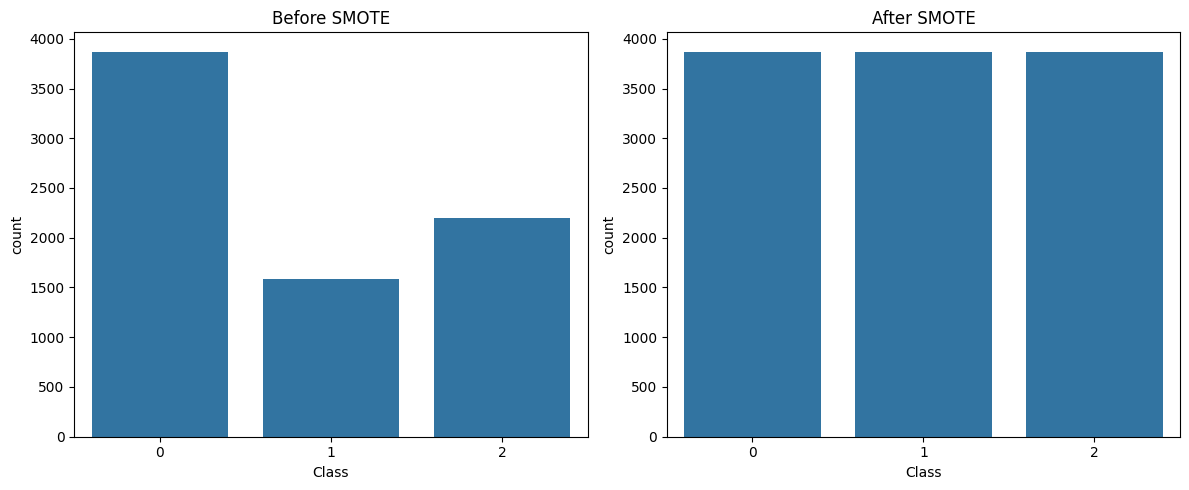

In [ ]:
# Before SMOTE
print("Original class distribution:")
print(y_train.value_counts())

# After SMOTE
print("\nBalanced class distribution:")
print(y_train_balanced.value_counts())

# Optional: visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Class")

sns.countplot(x=y_train_balanced, ax=axes[1])
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Class")

plt.tight_layout()
plt.show()

**Ensemble Model**

Accuracy: 0.9430 (94.30%)
AUC-ROC: 0.9875
CV Score: 0.9224 ± 0.0391

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       968
           1       0.85      0.88      0.87       396
           2       0.91      0.89      0.90       549

    accuracy                           0.94      1913
   macro avg       0.92      0.92      0.92      1913
weighted avg       0.94      0.94      0.94      1913


Confusion matrix


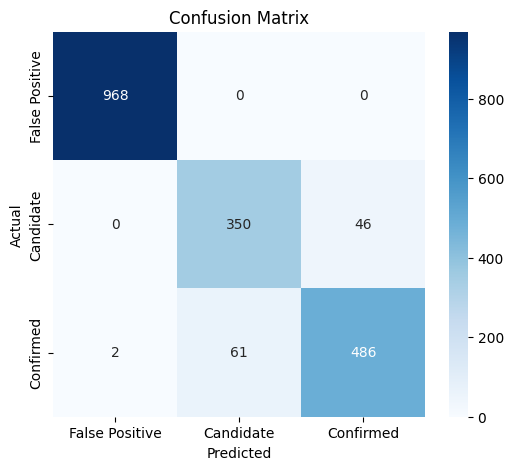

In [ ]:
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=18,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=9,
    learning_rate=0.08,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42,
    eval_metric="mlogloss"   # avoids deprecation warnings
)

cat_model = CatBoostClassifier(
    iterations=200,
    depth=9,
    learning_rate=0.08,
    random_seed=42,
    verbose=False
)

ensemble = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('cat', cat_model)],
    voting='soft'
)

ensemble.fit(X_train_balanced, y_train_balanced)

y_pred = ensemble.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, ensemble.predict_proba(X_test_scaled), multi_class='ovr')
cv_scores = cross_val_score(ensemble, X, y, cv=5)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"AUC-ROC: {auc:.4f}")
print(f"CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False Positive', 'Candidate', 'Confirmed'], yticklabels=['False Positive', 'Candidate', 'Confirmed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Exploring LightGBM on dataset**

In [ ]:
# Convert categorical columns to category dtype if any

results = []
n_splits = 5
n_repeats = 3  # number of times to run CV

for repeat in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42 + repeat)
    fold_accuracies = []
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        params = {
            'objective': 'multiclass',
            'num_class': 3,
            'metric': 'multi_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'seed': 42 + repeat,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'num_leaves': 31,
            'learning_rate': 0.05,
            'max_depth': -1
        }

        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            # early_stopping_rounds=50, # Removed this line
            # verbose_eval=False # Removed this line
        )

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred_labels = np.argmax(y_pred, axis=1)

        acc = accuracy_score(y_val, y_pred_labels)
        fold_accuracies.append(acc)

    mean_acc = np.mean(fold_accuracies)
    results.append(mean_acc)
    print(f"Repeat {repeat+1}, Mean accuracy: {mean_acc:.4f}")

print(f"Overall mean accuracy across {n_repeats} repeats: {np.mean(results):.4f}, Std: {np.std(results):.4f}")

Repeat 1, Mean accuracy: 0.9353
Repeat 2, Mean accuracy: 0.9393
Repeat 3, Mean accuracy: 0.9376
Overall mean accuracy across 3 repeats: 0.9374, Std: 0.0016


**Confusion matrix**

                precision    recall  f1-score   support

False Positive       1.00      1.00      1.00       967
     Candidate       0.89      0.81      0.85       396
     Confirmed       0.87      0.92      0.90       549

      accuracy                           0.94      1912
     macro avg       0.92      0.91      0.92      1912
  weighted avg       0.94      0.94      0.94      1912



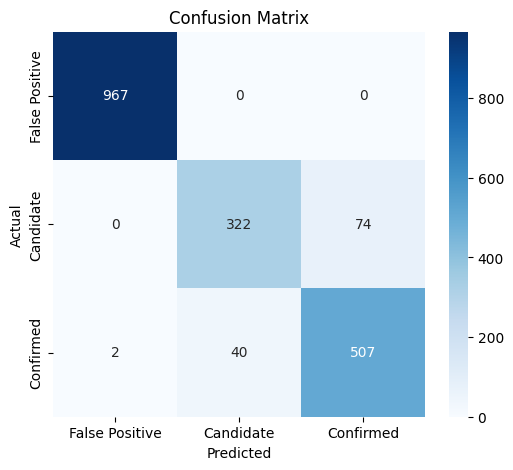

ROC-AUC Macro: 0.9866
ROC-AUC Weighted: 0.9901


In [ ]:
# y_val: true labels
# y_pred_labels: predicted class labels
# y_pred_probas: predicted probabilities for each class (shape: n_samples, n_classes)

# Classification report (precision, recall, f1-score)
print(classification_report(y_val, y_pred_labels, target_names=['False Positive', 'Candidate', 'Confirmed']))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False Positive', 'Candidate', 'Confirmed'], yticklabels=['False Positive', 'Candidate', 'Confirmed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC (One-vs-Rest)
# Binarize y_val for multiclass ROC AUC
n_classes = 3
y_val_bin = label_binarize(y_val, classes=[0,1,2])

# Macro ROC-AUC
roc_auc_macro = roc_auc_score(y_val_bin, y_pred, average='macro', multi_class='ovr')
print(f"ROC-AUC Macro: {roc_auc_macro:.4f}")

# Weighted ROC-AUC
roc_auc_weighted = roc_auc_score(y_val_bin, y_pred, average='weighted', multi_class='ovr')
print(f"ROC-AUC Weighted: {roc_auc_weighted:.4f}")

**Observing the columns by plotting in original dataset**

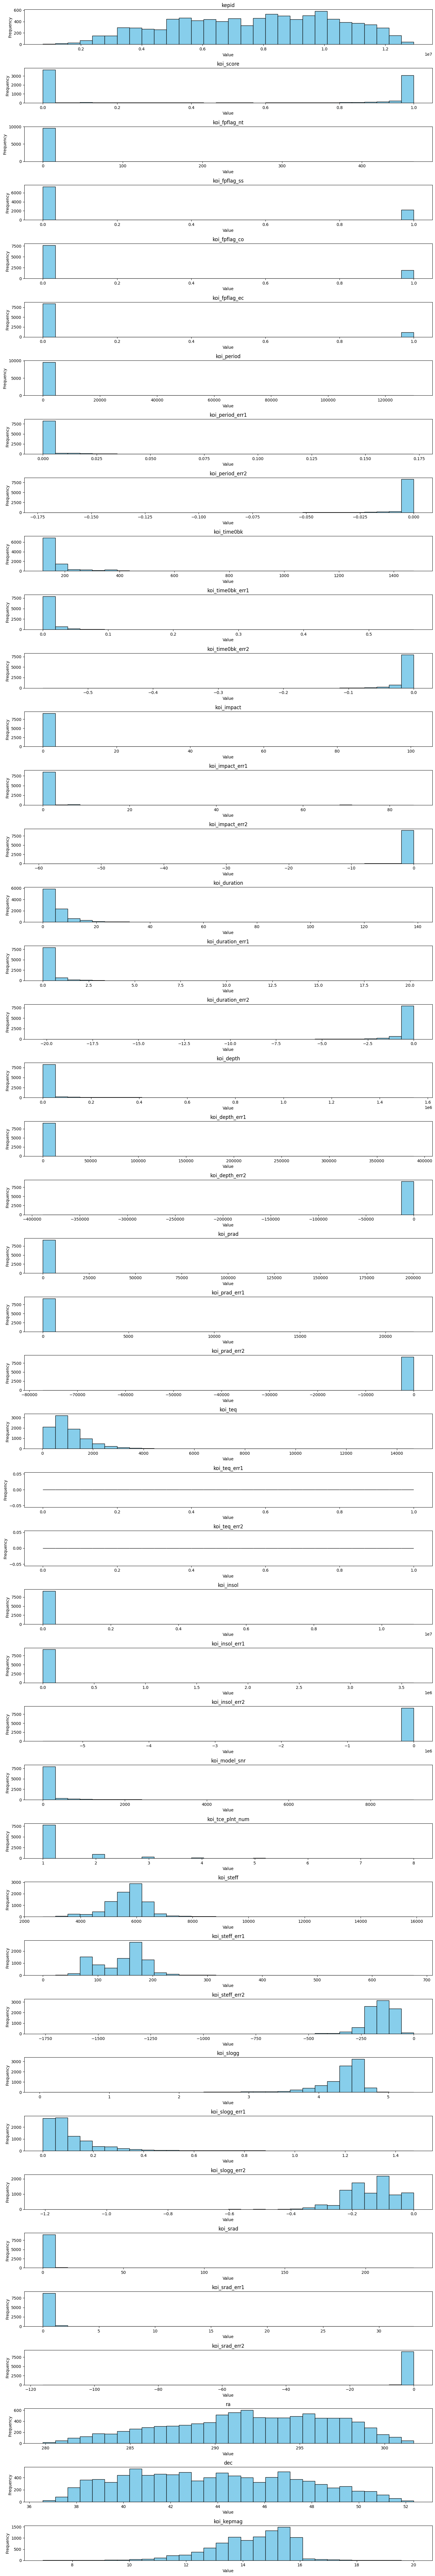

In [ ]:
# List of columns from your DataFrame info (assuming df available)
columns = [
    'kepid', 'koi_disposition', 'koi_pdisposition', 'koi_score',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
    'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff',
    'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag',
    'koi_pdisposition_bin', 'koi_disposition_encoded'
]

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()  # numeric columns

# # For categorical/object columns, we can do bar plot using value counts
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Plotting numerical columns histograms
plt.figure(figsize=(15, len(numeric_cols)*2))  # adjust size as needed
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    plt.hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plotting categorical columns bar plots (optional)
# plt.figure(figsize=(15, len(categorical_cols)*4))
# for i, col in enumerate(categorical_cols, 1):
#     plt.subplot(len(categorical_cols), 1, i)
#     df[col].value_counts().plot(kind='bar', color='lightgreen')
#     plt.title(col)
#     plt.xlabel('Category')
#     plt.ylabel('Count')
# plt.show()

**picking some columns for sample dataset**
**❗here we are using flag features**

In [ ]:
columns = [
    # "kepler_name",
    "kepoi_name",
    "koi_disposition", "koi_score",
    "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec",
    "koi_period", "koi_impact", "koi_depth", "koi_prad"
]

subset_df = df[columns]
subset_df.shape

**filtering by those where kepler_name is not null**

In [ ]:
filtered_df = subset_df[subset_df['kepler_name'].notna()]
filtered_df.shape

(2747, 7)

**counting the classes & sample distribution**

In [ ]:
count_candidate = (filtered_df['koi_disposition'] == 'CANDIDATE').sum()
count_false = (filtered_df['koi_disposition'] == 'FALSE POSITIVE').sum()
count_confirmed = (filtered_df['koi_disposition'] == 'CONFIRMED').sum()

print(count_candidate, count_false, count_confirmed)

0 2 2745


**selecting 15 equal samples**

In [ ]:
def select_rows_min_nans(df, class_value, n=15):
    class_df = df[df['koi_disposition'] == class_value].copy()
    class_df['nan_count'] = class_df.isna().sum(axis=1)
    class_df_sorted = class_df.sort_values('nan_count')
    return class_df_sorted.head(n).drop(columns=['nan_count'])

selected_dfs = [select_rows_min_nans(subset_df, val) for val in ['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE']]
result_df = pd.concat(selected_dfs).reset_index(drop=True)

In [ ]:
count_candidate = (result_df['koi_disposition'] == 'CANDIDATE').sum()
count_false = (result_df['koi_disposition'] == 'FALSE POSITIVE').sum()
count_confirmed = (result_df['koi_disposition'] == 'CONFIRMED').sum()

print(count_candidate, count_false, count_confirmed)

15 15 15


**dataframe of our 45 samples**

In [ ]:
result_df

,kepoi_name,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_impact,koi_depth,koi_prad
0,K02989.01,CONFIRMED,1.000,0,0,0,0,6.331252,0.094,306.6,1.31
1,K03061.01,CONFIRMED,0.981,0,0,0,0,7.328519,0.983,277.8,2.33
2,K03063.01,CONFIRMED,1.000,0,0,0,0,18.605205,0.093,242.5,1.94
3,K03147.01,CONFIRMED,0.997,0,0,0,0,39.442078,0.420,172.4,2.51
4,K00288.01,CONFIRMED,1.000,0,0,0,0,10.275325,0.315,209.7,3.04
5,K00289.01,CONFIRMED,1.000,0,0,0,0,26.629420,0.015,492.8,3.13
6,K00289.02,CONFIRMED,1.000,0,0,0,0,296.637582,0.429,2763.1,7.56
7,K00343.03,CONFIRMED,0.998,0,0,0,0,41.808503,0.011,190.4,1.67
8,K00344.01,CONFIRMED,1.000,0,0,0,0,39.309441,0.028,1132.1,2.87
9,K00345.01,CONFIRMED,1.000,0,0,0,0,29.884877,0.658,1275.7,2.81


In [ ]:
result_df.to_json('disposition.json', orient='records')